<style>
.wzor {
  /* width: auto; */
  /* padding: auto; */
  border: 0.5rem solid gray;
  /* margin: 0; */
  background-color: lightgray;
}
</style>


# Modele analizy danych

Tomasz Rodak

---

## Wykład X

ISLP, rozdział 5

---

## Literatura
   1. James, G., Witten, D., Hastie, T., Tibshirani, R., & Taylor,
      J. (2023). An Introduction to Statistical Learning: With
      Applications in Python.
      
      [ISLP](https://www.statlearning.com/)
   
   2. Bishop, C. M., & Nasrabadi, N. M. (2006). Pattern recognition and
      machine learning (Vol. 4, No. 4, p. 738). New York: springer. 
   
      [PRML](https://www.microsoft.com/en-us/research/people/cmbishop/prml-book/)
   
   3. Kroese, D. P., Botev, Z., Taimre, T., & Vaisman, R. (2019). Data
      science and machine learning: mathematical and statistical
      methods. CRC Press.
   
      [https://people.smp.uq.edu.au/DirkKroese/DSML/](https://people.smp.uq.edu.au/DirkKroese/DSML/)
   
   4. Hastie, T., Tibshirani, R., Friedman, J. H., & Friedman,
      J. H. (2009). The elements of statistical learning: data mining,
      inference, and prediction (Vol. 2, pp. 1-758). New York:
      springer.
   
      [https://hastie.su.domains/ElemStatLearn/](https://hastie.su.domains/ElemStatLearn/)
   
   5. Murphy, K. P. (2022). Probabilistic machine learning: an
      introduction. MIT press.
   
      [https://probml.github.io/pml-book/book1.html](https://probml.github.io/pml-book/book1.html)
   
   6. Murphy, K. P. (2023). Probabilistic machine learning: Advanced
      topics. MIT press.
   
      [https://probml.github.io/pml-book/book2.html](https://probml.github.io/pml-book/book2.html)
   
   7. Bishop, C. M., & Bishop, H (2024). Deep learning. Springer.
   
      [https://www.bishopbook.com/](https://www.bishopbook.com/)
   
   8. Goodfellow, I., Bengio, Y., & Courville, A. (2016). Deep learning. MIT press.
   
      [https://www.deeplearningbook.org/](https://www.deeplearningbook.org/)

---

## Spis treści

1. *Resampling*
    - Walidacja krzyżowa (*cross-validation*)
        - Metoda z jednym zbiorem walidacyjnym
        - Metoda *Leave-One-Out*
        - $k$-krotna walidacja krzyżowa
        - Wybór liczby foldów
        - Walidacja krzyżowa w problemie klasyfikacji

## Wykład X

ISLP, rozdział 5

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

In [2]:
from sklearn.model_selection import (
    train_test_split,
    KFold,
    LeaveOneOut
)
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.datasets import make_moons

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier

## 1. *Resampling*

*Resampling* to trenowanie modelu na (wielokrotnie) losowanych próbach ze zbioru danych treningowych po to, aby uzyskać jakąś dodatkową informację na temat trenowanego modelu.

Typowe przykłady *resamplingu* to:
1. Walidacja krzyżowa - służy do oceny błędu testowego modelu.
2. Bootstrap - służy do estymacji błędu standardowego estymatora.

### 1.1 Walidacja krzyżowa (*cross-validation*)

Celem walidacji krzyżowej jest oszacowanie błędu testowego modelu. Dzięki temu możemy porównać różne modele i wybrać ten, który charakteryzuje się najmniejszym błędem testowym (proces selekcji modelu).

Idealna sytuacja - mamy dostęp do bardzo dużej liczby danych. Wówczas:
* Dzielimy dane na trzy części: zbiór treningowy, walidacyjny i testowy, przy czym każdy z nich jest wystarczająco duży w porównaniu z elastycznością modelu.
* Trenujemy modele na zbiorze treningowym, minimalizując ich błąd treningowy.
* Obliczamy błędy modeli na zbiorze walidacyjnym, traktując je jako przybliżenie błędów testowych.
* Wybieramy model, który osiąga najmniejszy błąd walidacyjny.
* Obliczamy błąd wybranego modelu na zbiorze testowym, który służy jako ostateczna estymacja błędu testowego.

W praktyce zbiór danych jest zwykle na tyle mały, że nie możemy sobie pozwolić na radykalne zmniejszenie jego rozmiaru, gdyż prowadzi to do znacznej utraty informacji ze zbioru treningowego. W takiej sytuacji stosuje się walidację krzyżową.

#### 1.1.1 Metoda z jednym zbiorem walidacyjnym

- Zbiór walidacyjny to podzbiór zbioru danych, który nie jest wykorzystywany do uczenia modelu. 
- Zbiór treningowy to dopełnienie zbioru walidacyjnego (chyba, że mamy jeszcze osobny zbiór testowy, wtedy mamy podział na trzy rozłączne zbiory: treningowy, walidacyjny i testowy). Na zbiorze treningowym uczymy model.
- Na zbiorze walidacyjnym oceniamy jakość modelu licząc błąd predykcji, np. błąd średniokwadratowy MSE (*mean squared error*) w przypadku danych ilościowych. Błąd ten jest estymatorem błędu testowego.

To co nas interesuje to prawdziwy błąd testowy (błąd predykcji dla całej populacji). Błąd na zbiorze trenigowym jest złym estymatorem tego błędu, gdyż bardzo go zaniża. W rzeczywistości błąd na zbiorze trenigowym może spaść niemal do zera, jeśli tylko model będzie dostatecznie złożony (przeuczenie). 

Podany niżej przykład pokazuje, że błąd predykcji na zbiorze walidacyjnym istotnie zależy od tego, jakie obserwacje trafią do zbioru walidacyjnego. Oznacza to, że podczas selekcji modelu możemy wybrać model, który przez przypadek będzie miał najmniejszy błąd na zbiorze walidacyjnym, ale niekoniecznie będzie miał równie mały błąd na zbiorze testowym. Błąd na zbiorze walidacyjnym może zawyżać błąd testowy, zwłaszcza gdy pozostała część zbioru treningowego jest mała.

In [4]:
auto = pd.read_csv("datasets/Auto.csv", na_values="?")
auto.dropna(inplace=True)
X = auto["horsepower"]
y = auto["mpg"]

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)
test_errors = []

for degree in range(1, 11):
    pipe = Pipeline([
        ('poly', PolynomialFeatures(degree=degree)),
        ('reg', LinearRegression())
    ])
    model = pipe.fit(X_train.values.reshape(-1, 1), y_train)
    test_errors.append(mean_squared_error(y_test, model.predict(X_test.values.reshape(-1, 1))))

Text(0.5, 1.0, 'Test MSE vs Polynomial Degree')

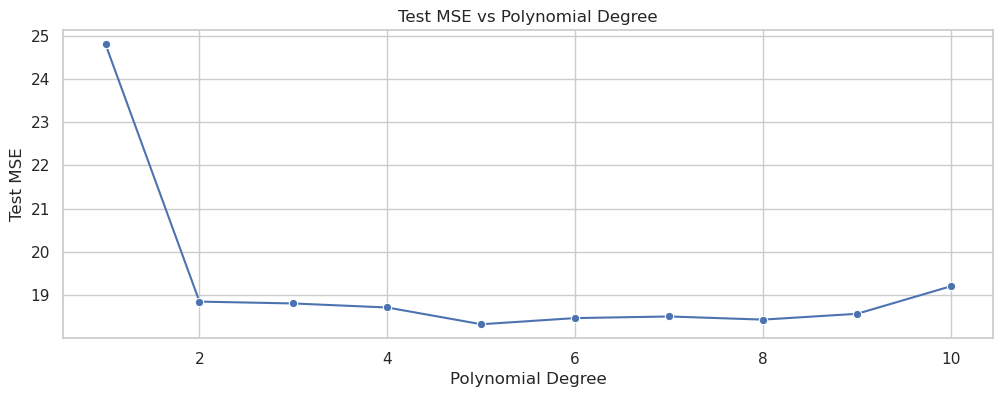

In [6]:
fig = plt.figure(figsize=(12, 4))
sns.lineplot(x=range(1, 11), y=test_errors, marker='o')
plt.xlabel("Polynomial Degree")
plt.ylabel("Test MSE")
plt.title("Test MSE vs Polynomial Degree")

In [7]:
test_errors = {}

for r_state in range(10, 20):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.5, random_state=r_state
    )
    test_errors[r_state] = []
    for degree in range(1, 11):
        pipe = Pipeline(
            [("poly", PolynomialFeatures(degree=degree)), ("reg", LinearRegression())]
        )
        model = pipe.fit(X_train.values.reshape(-1, 1), y_train)
        test_errors[r_state].append(
            mean_squared_error(y_test, model.predict(X_test.values.reshape(-1, 1)))
        )

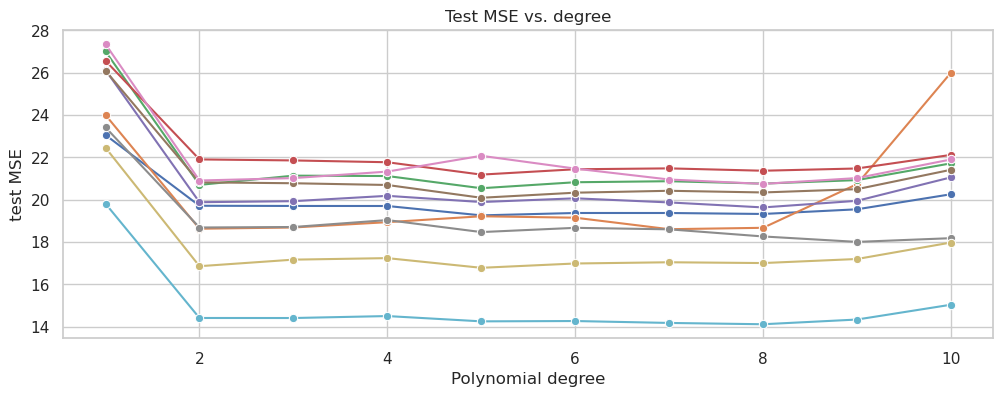

In [8]:
fig, ax = plt.subplots(figsize=(12, 4))
for r_state in range(10, 20):
    sns.lineplot(x=range(1, 11), y=test_errors[r_state], marker="o", ax=ax)
ax.set(xlabel="Polynomial degree", ylabel="test MSE", title="Test MSE vs. degree");

#### 1.1.2 Metoda *Leave-One-Out*

*Leave-One-Out* (*LOOCV* - *leave-one-out cross-validation*) - metoda walidacji krzyżowej, w której zbiór walidacyjny składa się z pojedynczej obserwacji; pozostałe obserwacje tworzą zbiór treningowy. 

Załóżmy, że mamy $n$ obserwacji $(x_1, y_1), \ldots, (x_n, y_n)$ w problemie regresji (zmienna $Y$ jest ilościowa; w problemie klasyfikacji postępujemy analogicznie). Jeśli $(x_i, y_i)$ jest obserwacją walidacyjną, to pozostałe obserwacje tworzą zbiór treningowy. Błąd predykcji na zbiorze walidacyjnym to

$$
\text{MSE}_i = (y_i - \hat{y}_i)^2,
$$

gdzie $\hat{y}_i$ to predykcja modelu dopasowanego do zbioru pozbawionego obserwacji $(x_i, y_i)$. Oszacowanie błędu predykcji na zbiorze testowym ma wówczas postać

$$
\text{CV}_{(n)} = \frac{1}{n} \sum_{i=1}^n \text{MSE}_i.
$$

Metoda *LOOCV* jest 
* kosztowna obliczeniowo - musimy dopasować $n$ modeli, gdzie $n$ jest liczbą obserwacji;
* ogólna - nie wymaga żadnych założeń co do modelu, można ją stosować do dowolnego problemu nadzorowanego uczenia maszynowego.

Poniżej podaję przykład zastosowania metody *LOOCV* do problemu regresji wielomianowej.

In [9]:
X, y = auto['horsepower'], auto['mpg']
expected_test_errors = [] # lista na średnie błędy dla każdego stopnia wielomianu
loo = LeaveOneOut()

for degree in range(1, 11):
    pipe = Pipeline([
        ('poly', PolynomialFeatures(degree=degree)),
        ('reg', LinearRegression())
    ])
    test_errors = []
    
    for train_idx, test_idx in loo.split(X): # loo.split(X) zwraca iterator indeksów
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        model = pipe.fit(X_train.values.reshape(-1, 1), y_train)
        test_errors.append(mean_squared_error(y_test, model.predict(X_test.values.reshape(-1, 1))))
    
    expected_test_errors.append(np.mean(test_errors))

Stopień, dla którego średnia błędów *LOOCV* na zbiorach walidacyjnych jest najmniejsza:

In [10]:
np.argmin(expected_test_errors) + 1

np.int64(8)

In [11]:
expected_test_errors

[np.float64(24.231513517929226),
 np.float64(19.248213124489407),
 np.float64(19.334984064147374),
 np.float64(19.424430310751493),
 np.float64(19.033203117664637),
 np.float64(19.166481248450083),
 np.float64(19.127248958673142),
 np.float64(19.012242709524095),
 np.float64(19.172519674845105),
 np.float64(19.905921116088905)]

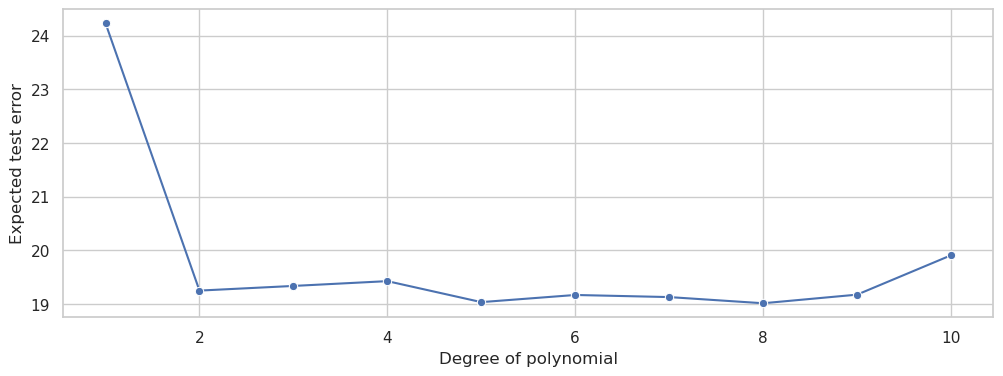

In [12]:
fig = plt.figure(figsize=(12, 4))
sns.lineplot(x=range(1, 11), y=expected_test_errors, marker='o')
plt.xlabel("Degree of polynomial")
plt.ylabel("Expected test error");

#### 1.1.3 $k$-krotna walidacja krzyżowa

Metoda *LOOCV* jest szczególnym (skrajnym) przypadkiem metody $k$-krotnej walidacji krzyżowej (*$k$-fold cross-validation*).
W *LOOCV* zbiór walidacyjny składa się z pojedynczej obserwacji ($k=n$), reszta obserwacji tworzy zbiór treningowy.
W metodzie $k$-krotnej dane dzielimy na $k$ rozłącznych podzbiorów o mniej więcej równej liczności. Każdy z tych podzbiorów jest zbiorem walidacyjnym, a pozostałe podzbiory tworzą zbiór treningowy. W $k$-krotnej walidacji krzyżowej trzeba zatem dopasować $k$ modeli. Jeśli przez $\text{MSE}_i$ oznaczymy błąd predykcji na $i$-tym zbiorze walidacyjnym, to oszacowanie błędu predykcji na zbiorze testowym ma postać

$$
\text{CV}_{(k)} = \frac{1}{k} \sum_{i=1}^k \text{MSE}_i.
$$

Bardzo często stosuje się metodę 5 lub 10-krotnej walidacji krzyżowej. Metoda ta jest 
* mniej kosztowna obliczeniowo niż *LOOCV*;
* ogólna - nie wymaga żadnych założeń co do modelu, można ją stosować do dowolnego problemu nadzorowanego uczenia maszynowego.

Poniżej podaję przykład z 10-krotnym zastosowaniem 10-krotnej walidacji krzyżowej do problemu regresji wielomianowej. Zauważ, że w tym przypadku szacowany błąd predykcji ma znacznie mniejsze wahania niż w przypadku podejścia z jednym zbiorem walidacyjnym.

In [13]:
X, y = auto['horsepower'], auto['mpg']
expected_test_errors = {}

for r_state in range(10):
    expected_test_errors[r_state] = [] # lista na średnie błędy dla każdego stopnia wielomianu
    kf = KFold(n_splits=10, shuffle=True, random_state=r_state)
    for degree in range(1, 11):
        pipe = Pipeline([
            ('poly', PolynomialFeatures(degree=degree)),
            ('reg', LinearRegression())
        ])
        test_errors = []
        
        for train_idx, test_idx in kf.split(X): 
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
            model = pipe.fit(X_train.values.reshape(-1, 1), y_train)
            test_errors.append(mean_squared_error(y_test, model.predict(X_test.values.reshape(-1, 1))))
        
        expected_test_errors[r_state].append(np.mean(test_errors))

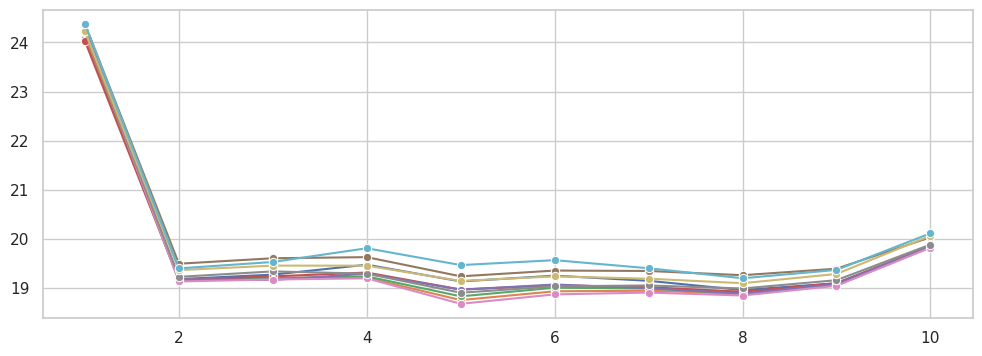

In [14]:
fig, ax = plt.subplots(figsize=(12, 4))
for r_state in range(10):
    sns.lineplot(x=range(1, 11), y=expected_test_errors[r_state], marker='o', ax=ax)

Porównanie prawdziwego błędu testowego z błędem szacowanym metodą *LOOCV* i 10-krotną walidacją krzyżową na danych syntetycznych.

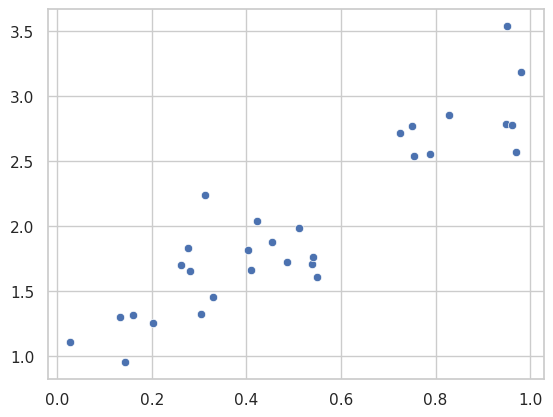

In [15]:
def f(x):
    return 1 + 2*x

# generowanie danych
n = 30
rng = np.random.default_rng(1)
x = rng.uniform(size=n)
y = f(x) + rng.normal(scale=0.3, size=n)
sns.scatterplot(x=x, y=y);

In [16]:
test_errors = {
    'true': [],
    'loocv': [],
    '10-fold': []
}

for degree in range(1, 14):
    pipe = Pipeline([
        ('poly', PolynomialFeatures(degree=degree)),
        ('reg', LinearRegression())
    ])
    model = pipe.fit(x.reshape(-1, 1), y)
    xnew = np.linspace(0, 1, 100_000)
    ynew = f(xnew) + rng.normal(scale=0.3, size=100_000)
    test_errors['true'].append(mean_squared_error(ynew, model.predict(xnew.reshape(-1, 1))))
    
    loo = LeaveOneOut()
    errors = []
    for train_idx, test_idx in loo.split(x):
        x_train, x_test = x[train_idx], x[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        model = pipe.fit(x_train.reshape(-1, 1), y_train)
        errors.append(mean_squared_error(y_test, model.predict(x_test.reshape(-1, 1))))
    test_errors['loocv'].append(np.mean(errors))
    
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    errors = []
    for train_idx, test_idx in kf.split(x):
        x_train, x_test = x[train_idx], x[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        model = pipe.fit(x_train.reshape(-1, 1), y_train)
        errors.append(mean_squared_error(y_test, model.predict(x_test.reshape(-1, 1))))
    test_errors['10-fold'].append(np.mean(errors))

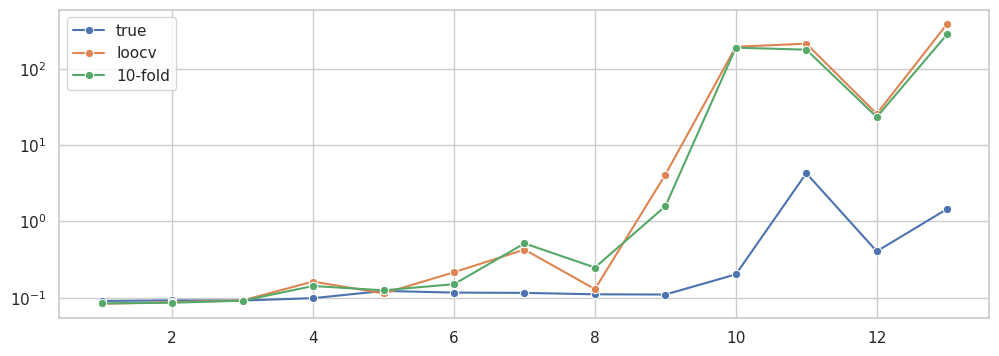

In [17]:
fig, ax = plt.subplots(figsize=(12, 4))

for key in test_errors:
    sns.lineplot(x=range(1, 14), y=test_errors[key], marker='o', ax=ax, label=key)
ax.set_yscale('log')

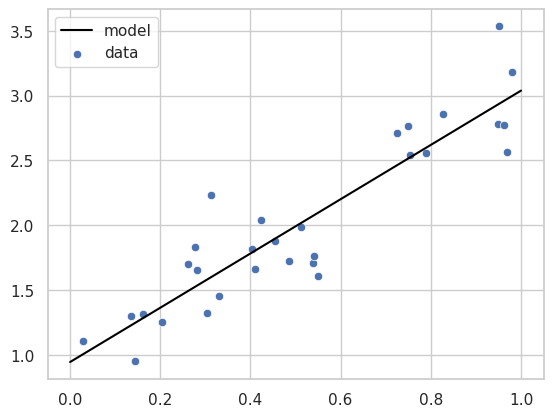

In [18]:
pipe = Pipeline([
    ('poly', PolynomialFeatures(degree=1)),
    ('reg', LinearRegression())
])
model = pipe.fit(x.reshape(-1, 1), y)
xnew = np.linspace(0, 1, 500)
ypred = model.predict(xnew.reshape(-1, 1))
sns.lineplot(x=xnew, y=ypred, color='black', label='model')
sns.scatterplot(x=x, y=y, label='data');

#### 1.1.4 Wybór liczby foldów

Toczy się dyskusja na temat wyboru optymalnej liczby foldów i schematu działania walidacji krzyżowej. Więcej szczegółów na ten temat znajdziesz [tutaj](https://stats.stackexchange.com/questions/61546/optimal-number-of-folds-in-k-fold-cross-validation-is-leave-one-out-cv-always) i w [ESL](https://hastie.su.domains/ElemStatLearn/) w paragrafie 7.10.

Można jednak sformułować pewne ogólne zasady:
1. *LOOCV* jest najbardziej kosztowna obliczeniowo.
2. W *LOOCV* próba treningowa jest duża (model będzie miał małe obciążenie), ale modele są silnie skorelowane.
3. W metodzie $k$-krotnej walidacji krzyżowej próba treningowa jest mniejsza (model będzie miał większe obciążenie), ale modele są mniej skorelowane.
4. W praktyce stosuje się metodę 5 lub 10-krotnej walidacji krzyżowej.
5. W przypadku małych zbiorów danych stosuje się *LOOCV*.

#### 1.1.5 Walidacja krzyżowa w problemie klasyfikacji

W problemie klasyfikacji stosuje się analogiczne podejście. Zbiór walidacyjny składa się z obserwacji, których klasa jest znana. Pozostałe obserwacje tworzą zbiór treningowy. Błąd predykcji na zbiorze walidacyjnym to odsetek błędnie zaklasyfikowanych obserwacji. 

Dla *LOOCV* błąd testowy szacujemy jako

$$
\text{CV}_{(n)} = \frac{1}{n} \sum_{i=1}^n \text{Err}_i,
$$

gdzie $\text{Err}_i=I(y_i \neq \hat{y}_i)$, a $\hat{y}_i$ to predykcja modelu w punkcie $x_i$.

Podobnie dla $k$-krotnej walidacji krzyżowej błąd testowy szacujemy jako

$$
\text{CV}_{(k)} = \frac{1}{k} \sum_{i=1}^k \text{Err}_i.
$$  

Błąd predykcji na $i$-tym zbiorze walidacyjnym to 

$$
\text{Err}_i = \frac{1}{|V_i|} \sum_{j \in V_i} I(y_j \neq \hat{y}_j),
$$

gdzie $V_i$ to indeksy obserwacji należących do $i$-tego foldu.

#### 1.1.5 Walidacja krzyżowa w problemie klasyfikacji

W problemie klasyfikacji walidacja krzyżowa przebiega analogicznie jak w regresji. Dane dzieli się na część treningową oraz walidacyjną, przy czym etykiety klas są znane dla wszystkich obserwacji. Model uczony jest na zbiorze treningowym, a jego jakość oceniana na zbiorze walidacyjnym.

Błąd predykcji w klasyfikacji definiuje się najczęściej jako średnią funkcji straty typu $0$-$1$, czyli odsetek błędnie zaklasyfikowanych obserwacji. Jest to równoważne mierze _accuracy_. Należy jednak pamiętać, że w przypadku niezbalansowanych klas może być korzystniejsze zastosowanie innych miar jakości klasyfikacji, np. precyzji, czułości, F1-score itp.

W przypadku walidacji _leave-one-out_ (LOOCV) estymator błędu testowego ma postać

\begin{equation*}
\mathrm{CV}_{(n)} = \frac{1}{n} \sum_{i=1}^n \mathrm{Err}_i,
\end{equation*}

gdzie

\begin{equation*}
\mathrm{Err}_i = I(y_i \neq \hat y_i),
\end{equation*}

a $\hat y_i$ oznacza predykcję modelu wytrenowanego na zbiorze danych z pominięciem $i$-tej obserwacji.

Dla $k$-krotnej walidacji krzyżowej zbiór danych dzielimy na $k$ rozłącznych foldów
$V_1,\dots,V_k$ o (w przybliżeniu) równej liczności. Estymator błędu testowego
definiujemy jako

\begin{equation*}
\mathrm{CV}_{(k)} = \frac{1}{k} \sum_{i=1}^k \mathrm{Err}_i,
\end{equation*}

gdzie błąd na $i$-tym foldzie walidacyjnym dany jest wzorem

\begin{equation*}
\mathrm{Err}_i = \frac{1}{|V_i|} \sum_{j \in V_i} I(y_j \neq \hat y_j),
\end{equation*}

a $\hat y_j$ jest predykcją modelu wytrenowanego na wszystkich obserwacjach
spoza foldu $V_i$.

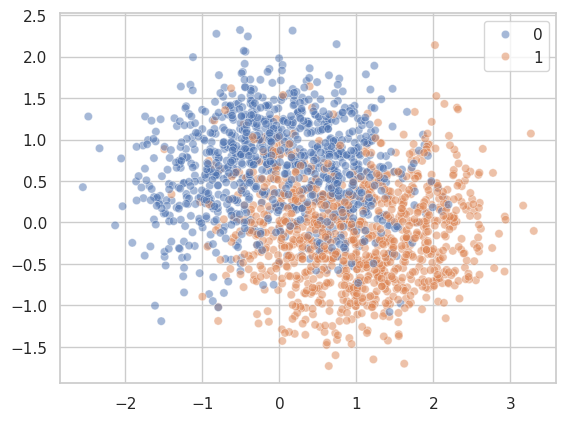

In [19]:
n = 2000
X, y = make_moons(n_samples=n, noise=.5, random_state=0)
sns.scatterplot(x=X[:,0], y=X[:,1], hue=y, alpha=.5);

In [20]:
n_neighbors = np.arange(100, 0, -1)
kf = KFold(n_splits=10)
test_errors = []

for n in n_neighbors:
    errors = []
    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        model = KNeighborsClassifier(n_neighbors=n)
        model.fit(X_train, y_train)
        errors.append(1 - model.score(X_test, y_test))
    test_errors.append(np.mean(errors))

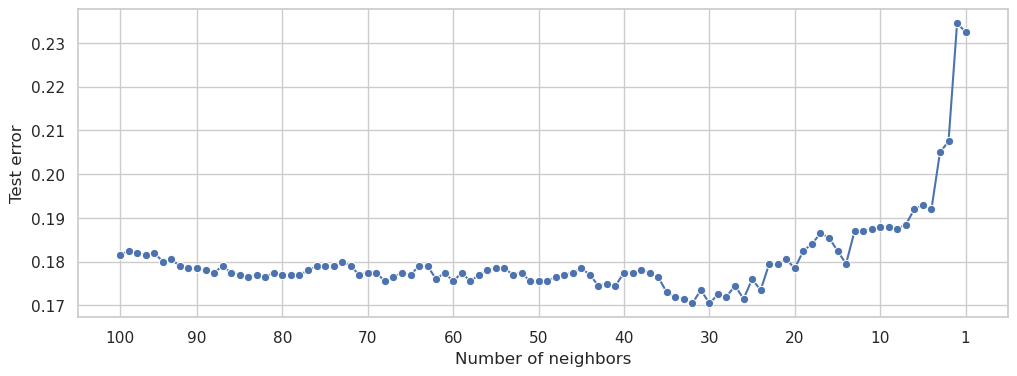

In [21]:
import matplotlib.ticker as ticker

fig, ax = plt.subplots(figsize=(12, 4))

sns.lineplot(x=n_neighbors, y=test_errors[::-1], marker='o', ax=ax)
ax.xaxis.set_major_locator(ticker.FixedLocator(list(range(100, 0, -10))+[1]))
tick_labels = ['1'] + [str(i) for i in range(10, 110, 10)]
ax.set_xticklabels(tick_labels)
ax.set(xlabel="Number of neighbors", ylabel="Test error");